# Image processing notebook: From overlap corrected to transmission 

### 00 - Introduction
This notebook demonstrates the use of Jupyter for a Time-of-Flight image processing task. The data corresponds to ToF neutron imaging of coin cells filled with different organic compounds and electrolytes.

*Note: This notebook was written and tested on Windows 10. Running on Mac or Linux machines may need adjustments, e.g. in the path specificationsApplied processing*

### Applied processing
The following processing parts from the averaged pulses, which were already overlap corrected:

- filtering
- Pulse averaging and separtion per experiments
- identification and weighting of OBs for each experiment
- scrubbing correction
- intensity correction
- transmission image generation


### Important Considerations
This notebook starts from the point **after** the overlap correction presented in the image below. This step before (done in a separate notebook) format its destionation directory to be taken by this notebook to process the images correctly.

Transmission Image:

\begin{equation}
T_{img} \rightarrow \frac{I}{I_{0}}=\frac{\frac{\bar{Img}}{OB_{weight}} - SBKG_{img}}{\frac{\bar{Ref}}{OB_{weight}} - SBKG_{ref}}
\end{equation}

## 01 Initial settings
Import all the required libraries

In [1]:
import sys
sys.path.append(r'..\framework')
sys.path.append(r'..\proc_functions')
from stack_proc_func import *
from img_utils_mod import *
import scipy.signal as sp
%matplotlib inline

### Select directories
Select the source directory. This directory is where the images **after** the overlap correction were saved.
Select the destination directory. Here is where the transmission images are going to be saved.

In [5]:
# %load select_directory('src_dir')
src_dir = r"D:\PSI21_08NI\Processed\00_Overlap_corrected\exp107_epithermal"

In [6]:
# %load select_directory('dst_dir')
dst_dir = r"D:\PSI21_08NI\Processed\01_Transmission_Results\exp107_epithermal"

### Select working folders
Once the directories are loaded, you can start to do a selection of the folders you want to process. <br>
The next function loads the folders availableas a visual aid. However, you can avoid this step just by looking at the source folder in the windows explorer.

In [7]:
all_folders = prep_stack_dict(src_dir)
for key in all_folders.keys():
    print(key)

000_ob_01
001_ref
002_ob_02
003_temp_00_p17_ob
003_temp_00_p25_ob
004_temp_00_p25_batch01
005_temp_00_p25_batch02
006_temp_00_p25_batch03


For this test we will select some folders that we want to process as '`proc_folder`' and our reference as '`ref_folder`'.

* _note: `proc-folder` can take several strings as value, for that reason is a list of strings. On the other hand, `ref_folder` is always one, for that reason it is just a string._

In [24]:
proc_folder = []
proc_folder1 = ['004_temp_00_p25_batch01']
proc_folder2 = ['005_temp_00_p25_batch02']
proc_folder3 = ['006_temp_00_p25_batch03']
ref_folder = '001_ref'

## 02 Filtering process definition
Here we define the process that each image will have before the pulse averaging (if any).

* _note: The sequence generated must contain the names of each function and at the end the 'stack_avg' function which performs the pulse averaging. <br> i.e.  test_seq = [`function_1`, `function_2`, `more functions`, `stack_avg`]_

### White spots filtering
The white spots are removed by applying a median filter of size 'ws_filter_size'

In [9]:
from skimage.filters import gaussian, median, meijering
from skimage.morphology import disk

def ws_filter(src_img, ws_filter_size, **kwargs):
    return sp.medfilt2d(src_img.astype('float32'), ws_filter_size)

def gaussian_filter(x, sigma,**kwargs):
    return gaussian(x, sigma)

def median_filter(x, **kwargs):
    return median(x)

In [10]:
test_seq = [ws_filter,stack_avg]

## 03 Filter testing
The `test_filter_stack` function test the filters given in the `test_seq` list and prints the image.<br> A selection of a testing folder named `test_folder` is required to proceed with the image checkout. <br> 
-If no specific image is selected, it automatically selects the image at the median point in the stack.<br>

* _note: if the filtering functions inserted in the `test_seq` require aditional arguments or variables, they can be given as `**kwargs` inside the function parameters. i.e `ws_filter_size = 5` was given in the function for the ws_filter usage._

Averaging:  50%|████████████████▌                | 4/8 [00:00<00:00, 33.71it/s]

ws_filter_size = 3


Averaging: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 33.43it/s]


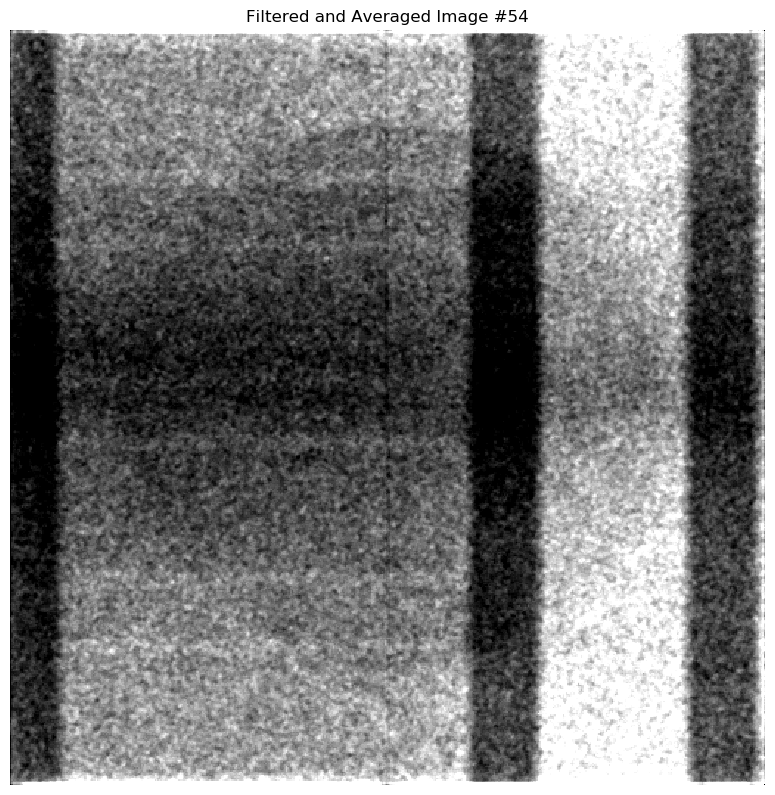

In [16]:
test_folder = '004_temp_00_p25_batch01'
img = test_filtering_stack (src_dir,dst_dir, test_folder = test_folder, 
                            test_seq = test_seq, give_data=True, ws_filter_size = 3)

### Confirm the operations sequence
After you are satisfied with the result, write the real sequence `seq` that will be used for all the images.

In [17]:
seq = [ws_filter, stack_avg]

## 04 Selecting ROIS and other variables
Each campaign is different, if there are some requirements that the processing require, you can insert them as `**kwargs`. <br>
In the case of this specific campaing (PSI19_03NI), the MCP detector did not adquire correctly the first 9 images in each process. For that reason, the processing needs to remove those images. Thus, we can slice the folder by givin the values that we want with `start_slice` and `end_slice`. 

* _note: If we want to slice the starting but not the end, it is just required to give the beginning (`start_slice`) and leave `end_slice` blank as in the next example._

In [18]:
start_slice = 1
end_slice = 100

### ROI selection (program still needs the implementation of the CSV option)
One important parameter are the ROIs, specifically the non-changing-area (nca). Fo that reason, we do a use an interactive command to select them.

If more ROIs were selected (other than the first -nca-), these will be used to create a CSV file at the end with the all the transmission values included. <br>**waiting for implementation in stack_batch_proc**

The window for ROI selection still open in a separate window, I am checking the way to have it printed in the notebook to avoid changing any mistake 

* _note: the option 'flip_image = True' is required to agree with imageJ format of showing the image. In stack_batch_proc it is implemented in the intensity correction part (TFC_corr). The modifications done to img_utils _

**to select several ROIs: for each ROI selected, press ENTER, when finish, press ESC**

In [19]:
# %load select_rois(img, list_rois = ['nca'])
nca = [379, 17, 63, 477]

To agree with the selected ROIs, the image is shown with its labeling, being label 1 the first ROI selected i.e nca, second label 2 and so forth

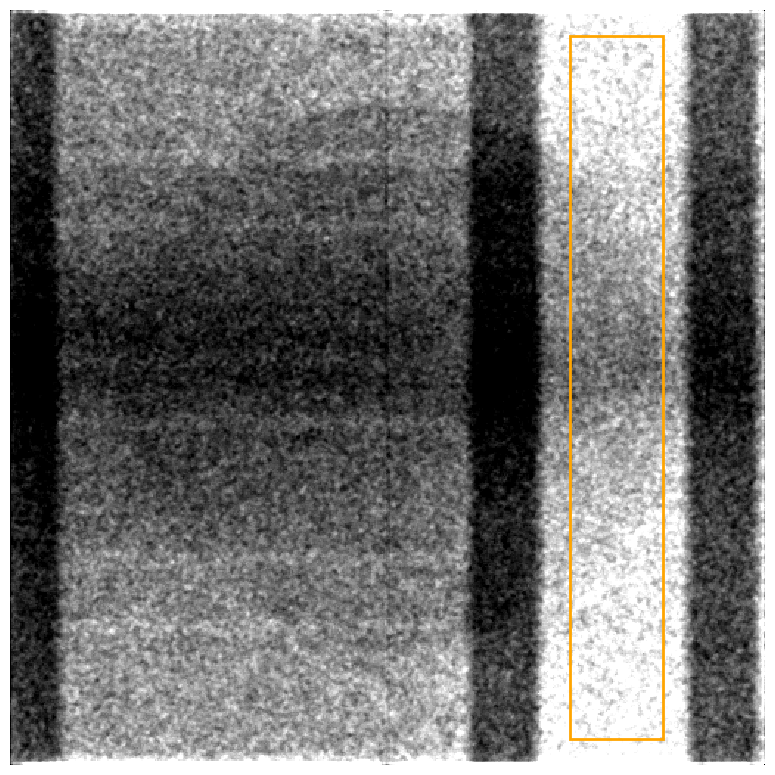

In [20]:
show_img(img, dr = [nca])

## 05 BB mask
The BB mask is a fits image saved in the source directory. if all the experiments are aligned, one BB mask can be used. However, if there are misalignments, several BB masks must be given. 

**a program that creates the BB mask for that specific experiment would be extremly useful in this case so we do not need to care anymore about BBs**

For the moment being and as an example, the program takes a real (for testing) BB mask to include it in the process

In [21]:
ref_mask_img = get_img(os.path.dirname(src_dir) + '/mask_ref.fits')
img_mask_img = get_img(os.path.dirname(src_dir) + '/mask_batch01.fits')

## 06 Run first transmission image test 
This will give you one transmission image as an example of the whole process.

Set a starting and ending slice (to speed up the process, do not choose more tan 10 images or do it in different parts of the spectrum)

In [22]:
stack_test = stack_batch_proc (src_dir, dst_dir, ref_mask_img,img_mask_img, proc_folder = [test_folder], 
         ref_folder = ref_folder, avg_seq = seq, save_results = False, start_slice = 60, end_slice = 70, 
         print_TFC = True, nca=nca, ws_filter_size = 3)

start_slice = 60
end_slice = 70
print_TFC = True
nca = [379, 17, 63, 477]
ws_filter_size = 3


Processing: 100%|██████████████████████████████| 10/10 [00:03<00:00,  2.98it/s]

3.369952093254771
3.288526919887842
3.216025212939867
2.804819792082533
2.740709658847938
2.678184599803533
2.6138060079028294
2.5521868303762467
2.4800337892705873
2.405475626634195
Total execution time: 36s


### Testing the NCA region 

This region is characterized for having a value of 1. The process might have an error if this region has values greater that 0.05% of the theoretical one.

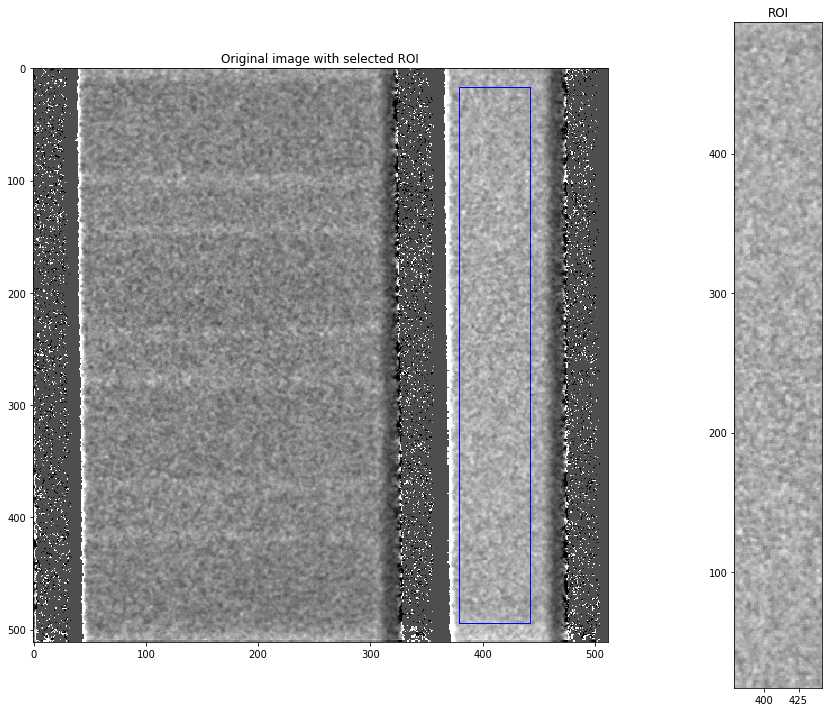

[1.000489232378333, 1.0005055651280241, 1.000446031848943, 1.0004929408711714, 1.000489650477427, 1.0005869106319214, 1.0005131073007076, 1.0004809242022719, 1.0004561071839753, 1.0005000733495035]
1.0004960543372277


In [25]:
nca_reg =[]
for key, values in stack_test.items():
    img = values
    for im in img:
        nca_reg.append(np.mean(roi_in_image(im,nca)))
    np.mean(roi_in_image(img[int(len(values)/2)],nca, show= True))
print(nca_reg)
print(np.mean(nca_reg))

## 07 Full image processing
After all tests are correct, you can process and do the full image process for all the folders that you want with the captured parameters.

The result of using the next function is that all the transmission images generated with it are saved with a .fits extension in your destination folder and HE and LE sections will be saved in another 2 folders.

__Note:__ If you are sure fo the process, you can leave `proc_folder` empty `proc_folder = []`,the program will process all folders included in the source directory.

In [26]:
img_mask_img = get_img(os.path.dirname(src_dir) + '/mask_batch01.fits')
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder1, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, start_slice= start_slice,
                  end_slice = end_slice)

Averaging:   0%|                                         | 0/6 [00:00<?, ?it/s]

nca = [379, 17, 63, 477]
ws_filter_size = 3
start_slice = 1
end_slice = 100


Processing: 100%|██████████████████████████████| 99/99 [00:34<00:00,  2.84it/s]


Total execution time: 409s


In [27]:
img_mask_img = get_img(os.path.dirname(src_dir) + '/mask_batch02.fits')
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder2, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, start_slice= start_slice,
                  end_slice = end_slice)

Averaging:   0%|                                         | 0/6 [00:00<?, ?it/s]

nca = [379, 17, 63, 477]
ws_filter_size = 3
start_slice = 1
end_slice = 100


Processing: 100%|██████████████████████████████| 99/99 [00:35<00:00,  2.75it/s]


Total execution time: 385s


In [28]:
img_mask_img = get_img(os.path.dirname(src_dir) + '/mask_batch03.fits')
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder3, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, start_slice= start_slice,
                  end_slice = end_slice)

Averaging:   0%|                                         | 0/6 [00:00<?, ?it/s]

nca = [379, 17, 63, 477]
ws_filter_size = 3
start_slice = 1
end_slice = 100


Processing: 100%|██████████████████████████████| 99/99 [00:33<00:00,  2.97it/s]


Total execution time: 382s
